In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams.update({'font.size': 18})

import tensorflow as tf
import tensorflow.keras.backend as kbackend
from tensorflow.keras import layers as klayers
from tensorflow.keras import models as kmodels
kbackend.set_floatx('float64')

orange = '#FA4616' #Gator orange
blue = '#0021A5' #Gator blue

In [3]:
logit = lambda p: np.log(p) - np.log1p(-p)

In [4]:
class four_momentum:
    def set_polar(self, eta, phi, pt, mass):
        self.eta = np.array(eta)
        self.phi = np.array(phi)
        self.pt = np.array(pt)
        self.mass = np.array(mass)
        
        self.compute_cartesian()
    
    def set_cartesian(self, px, py, pz, E):
        self.px = np.array(px)
        self.py = np.array(py)
        self.pz = np.array(pz)
        self.E = np.array(E)
        
        self.compute_polar()
        
    def compute_cartesian(self):
        self.px = self.pt * np.cos(self.phi)
        self.py = self.pt * np.sin(self.phi)
        self.pz = self.pt * np.sinh(self.eta)
        self.E = (self.px**2 + self.py**2 + self.pz**2 + self.mass**2)**.5
    
    def compute_polar(self):
        self.phi = np.arctan2(self.py, self.px)
        self.pt = (self.px**2 + self.py**2)**.5
        self.mass = (self.E**2 - self.px**2 - self.py**2 - self.pz**2)**.5
        
        self.eta = np.arcsinh(self.pz / self.pt)
    
    def __add__(self, other):
        to_return = four_momentum()
        to_return.set_cartesian(self.px+other.px, self.py+other.py, self.pz+other.pz, self.E+other.E)
        return to_return
    
    def transverse_rotate(self, delta_phi):
        self.phi += delta_phi
        self.px = self.pt * np.cos(self.phi)
        self.py = self.pt * np.sin(self.phi)
        self.phi = np.arctan2(self.py, self.px)
    
    def copy(self):
        to_return = four_momentum()
        
        to_return.px = self.px.copy()
        to_return.py = self.py.copy()
        to_return.pz = self.pz.copy()
        to_return.E = self.E.copy()
        
        to_return.eta = self.eta.copy()
        to_return.phi = self.phi.copy()
        to_return.pt = self.pt.copy()
        to_return.mass = self.mass.copy()
        
        return to_return
    
    def swap(self, other, swap_flag):
        out_1 = four_momentum()
        out_2 = four_momentum()
        
        swap_loc = np.where(swap_flag, np.ones(self.px.shape, dtype=np.int8), np.zeros(self.px.shape, dtype=np.int8))
        
        out_1.px = np.choose(swap_loc, [self.px, other.px])
        out_1.py = np.choose(swap_loc, [self.py, other.py])
        out_1.pz = np.choose(swap_loc, [self.pz, other.pz])
        out_1.E = np.choose(swap_loc, [self.E, other.E])
        
        out_1.eta = np.choose(swap_loc, [self.eta, other.eta])
        out_1.phi = np.choose(swap_loc, [self.phi, other.phi])
        out_1.pt = np.choose(swap_loc, [self.pt, other.pt])
        out_1.mass = np.choose(swap_loc, [self.mass, other.mass])
        
        out_2.px = np.choose(swap_loc, [other.px, self.px])
        out_2.py = np.choose(swap_loc, [other.py, self.py])
        out_2.pz = np.choose(swap_loc, [other.pz, self.pz])
        out_2.E = np.choose(swap_loc, [other.E, self.E])
        
        out_2.eta = np.choose(swap_loc, [other.eta, self.eta])
        out_2.phi = np.choose(swap_loc, [other.phi, self.phi])
        out_2.pt = np.choose(swap_loc, [other.pt, self.pt])
        out_2.mass = np.choose(swap_loc, [other.mass, self.mass])
        
        return out_1, out_2

## Hacky lhco file processing:
Creates bg_mu1, bg_mu2, bg_b1, bg_b2, sig_mu1, sig_mu2, sig_b1, sig_b2

In [5]:
jetres_str = '25'

bg_file = f'data_files/2_smeared_lhco/background_ZZ_mumubb_smeared_{jetres_str}.lhco'
sig_file = f'data_files/2_smeared_lhco/signal_ZH_mumubb_smeared_{jetres_str}.lhco'

with open(bg_file) as f:
    raw = f.read()

events = raw.strip().split("# typ eta            phi              pt               jmass  ntrk  btag  had/em   dummy  dummy")[1:]

bg_mu1_polar = []
bg_mu2_polar = []
bg_b1_polar = []
bg_b2_polar = []

for e in events:
    tmp_mu1, tmp_mu2 = e.strip().split('\n')[1:3]
    tmp_b1, tmp_b2 = e.strip().split('\n')[3:5]
    
    bg_mu1_polar.append([float(_) for _ in tmp_mu1.split()[2:6]])
    bg_mu2_polar.append([float(_) for _ in tmp_mu2.split()[2:6]])
    bg_b1_polar.append([float(_) for _ in tmp_b1.split()[2:6]])
    bg_b2_polar.append([float(_) for _ in tmp_b2.split()[2:6]])

bg_mu1_polar = np.array(bg_mu1_polar)
bg_mu2_polar = np.array(bg_mu2_polar)
bg_b1_polar = np.array(bg_b1_polar)
bg_b2_polar = np.array(bg_b2_polar)

bg_mu1 = four_momentum()
bg_mu2 = four_momentum()
bg_b1 = four_momentum()
bg_b2 = four_momentum()

bg_mu1.set_polar(bg_mu1_polar[:,0], bg_mu1_polar[:,1], bg_mu1_polar[:,2], bg_mu1_polar[:,3])
bg_mu2.set_polar(bg_mu2_polar[:,0], bg_mu2_polar[:,1], bg_mu2_polar[:,2], bg_mu2_polar[:,3])
bg_b1.set_polar(bg_b1_polar[:,0], bg_b1_polar[:,1], bg_b1_polar[:,2], bg_b1_polar[:,3])
bg_b2.set_polar(bg_b2_polar[:,0], bg_b2_polar[:,1], bg_b2_polar[:,2], bg_b2_polar[:,3])

del bg_mu1_polar, bg_mu2_polar, bg_b1_polar, bg_b2_polar, events

with open(sig_file) as f:
    raw = f.read()

events = raw.strip().split("# typ eta            phi              pt               jmass  ntrk  btag  had/em   dummy  dummy")[1:]

sig_mu1_polar = []
sig_mu2_polar = []
sig_b1_polar = []
sig_b2_polar = []

for e in events:
    tmp_mu1, tmp_mu2 = e.strip().split('\n')[1:3]
    tmp_b1, tmp_b2 = e.strip().split('\n')[3:5]
    
    sig_mu1_polar.append([float(_) for _ in tmp_mu1.split()[2:6]])
    sig_mu2_polar.append([float(_) for _ in tmp_mu2.split()[2:6]])
    sig_b1_polar.append([float(_) for _ in tmp_b1.split()[2:6]])
    sig_b2_polar.append([float(_) for _ in tmp_b2.split()[2:6]])

sig_mu1_polar = np.array(sig_mu1_polar)
sig_mu2_polar = np.array(sig_mu2_polar)
sig_b1_polar = np.array(sig_b1_polar)
sig_b2_polar = np.array(sig_b2_polar)

sig_mu1 = four_momentum()
sig_mu2 = four_momentum()
sig_b1 = four_momentum()
sig_b2 = four_momentum()

sig_mu1.set_polar(sig_mu1_polar[:,0], sig_mu1_polar[:,1], sig_mu1_polar[:,2], sig_mu1_polar[:,3])
sig_mu2.set_polar(sig_mu2_polar[:,0], sig_mu2_polar[:,1], sig_mu2_polar[:,2], sig_mu2_polar[:,3])
sig_b1.set_polar(sig_b1_polar[:,0], sig_b1_polar[:,1], sig_b1_polar[:,2], sig_b1_polar[:,3])
sig_b2.set_polar(sig_b2_polar[:,0], sig_b2_polar[:,1], sig_b2_polar[:,2], sig_b2_polar[:,3])

del sig_mu1_polar, sig_mu2_polar, sig_b1_polar, sig_b2_polar, events

## Neural Network input prep:

In [6]:
bg_b_high, bg_b_low = bg_b1.swap(bg_b2, bg_b1.pt < bg_b2.pt)
bg_mu_sum = bg_mu1 + bg_mu2

rotation_angle = -bg_b_high.phi
for obj in [bg_b_high, bg_b_low, bg_mu_sum]:
    obj.transverse_rotate(rotation_angle)

bg_attr_list = [None]*10

bg_attr_list[0] = (bg_b_high+bg_b_low).mass
bg_attr_list[1] = bg_b_high.eta
bg_attr_list[2] = bg_b_high.pt
bg_attr_list[3] = bg_b_low.eta
bg_attr_list[4] = bg_b_low.phi
bg_attr_list[5] = bg_b_low.pt / bg_b_high.pt
bg_attr_list[6] = bg_mu_sum.eta
bg_attr_list[7] = bg_mu_sum.phi
bg_attr_list[8] = bg_mu_sum.pt
bg_attr_list[9] = bg_mu_sum.mass

####

sig_b_high, sig_b_low = sig_b1.swap(sig_b2, sig_b1.pt < sig_b2.pt)
sig_mu_sum = sig_mu1 + sig_mu2

rotation_angle = -sig_b_high.phi
for obj in [sig_b_high, sig_b_low, sig_mu_sum]:
    obj.transverse_rotate(rotation_angle)

sig_attr_list = [None]*10

sig_attr_list[0] = (sig_b_high+sig_b_low).mass
sig_attr_list[1] = sig_b_high.eta
sig_attr_list[2] = sig_b_high.pt
sig_attr_list[3] = sig_b_low.eta
sig_attr_list[4] = sig_b_low.phi
sig_attr_list[5] = sig_b_low.pt / sig_b_high.pt
sig_attr_list[6] = sig_mu_sum.eta
sig_attr_list[7] = sig_mu_sum.phi
sig_attr_list[8] = sig_mu_sum.pt
sig_attr_list[9] = sig_mu_sum.mass

####

bg_input = np.stack(bg_attr_list, axis=1)
bg_label = np.zeros(len(bg_input))

sig_input = np.stack(sig_attr_list, axis=1)
sig_label = np.ones(len(sig_input))

## Train - Test splitting:

In [7]:
X = np.concatenate([bg_input, sig_input])
y = np.concatenate([bg_label, sig_label])

np.random.seed(0)
shuffle_index = np.random.permutation(len(X))
X = X[shuffle_index, :]
y = y[shuffle_index]

train_test_break_point = int(0.7*len(X))
X_train = X[:train_test_break_point, :]
X_test = X[train_test_break_point:, :]
y_train = y[:train_test_break_point]
y_test = y[train_test_break_point:]

## Neural Network architecture:

In [8]:
tf.random.set_seed(0)

model = kmodels.Sequential()
model.add(tf.keras.Input(X_train.shape[1]))
model.add(klayers.Dense(units=16, activation='sigmoid'))
model.add(klayers.Dense(units=32, activation='sigmoid'))
model.add(klayers.Dropout(0.2))
model.add(klayers.Dense(units=32, activation='sigmoid'))
model.add(klayers.Dropout(0.2))
model.add(klayers.Dense(units=32, activation='sigmoid'))
model.add(klayers.Dense(units=16, activation='sigmoid'))
model.add(klayers.Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                176       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                5

In [9]:
f"The codeblock below loads the trained model from the file 'NN_model_jetres_{jetres_str}.h5'"

# seed = 1, epochs = 25 for jetres = 20, 25

#tf.random.set_seed(1)
#model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25)
#model.save(f'NN_saves/NN_model_jetres_{jetres_str}.h5')

"The codeblock below loads the trained model from the file 'NN_model_jetres_25.h5'"

In [10]:
model = kmodels.load_model(f'NN_saves/NN_model_jetres_{jetres_str}.h5')

In [11]:
bg_label_pred = model.predict(bg_input)
sig_label_pred = model.predict(sig_input)

save_dir = 'data_files/3_thickbrick_input'
np.savetxt(f'{save_dir}/background_mjj_p_jetres_{jetres_str}.txt', np.stack([bg_input[:,0], bg_label_pred[:,0]], axis=1))
np.savetxt(f'{save_dir}/signal_mjj_p_jetres_{jetres_str}.txt', np.stack([sig_input[:,0], sig_label_pred[:,0]], axis=1))

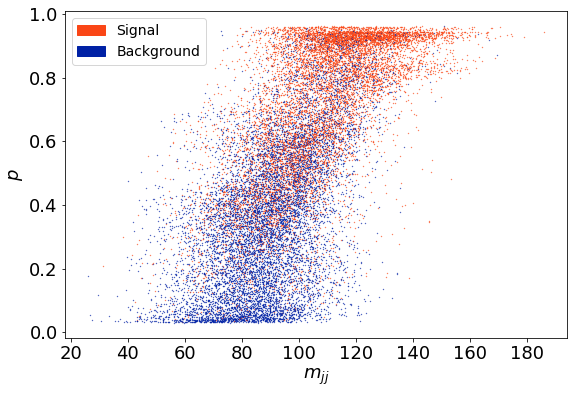

In [12]:
fig, ax = plt.subplots(figsize=(9,6))

plot_batch_size = 100
plot_batch_count = 100

for i in range(plot_batch_count):
    start, end = i*plot_batch_size, (i+1)*plot_batch_size
    ax.scatter(sig_input[start:end, 0], sig_label_pred[start:end], color=orange, s=.1)
    ax.scatter(bg_input[start:end,0], bg_label_pred[start:end], color=blue, s=.1)

ax.set_xlabel(r'$m_{jj}$')
ax.set_ylabel(r'$p$')

sig_patch = mpatches.Patch(color=orange, label='Signal')
bg_patch = mpatches.Patch(color=blue, label='Background')
ax.legend(handles=[sig_patch, bg_patch], fontsize=14)
None

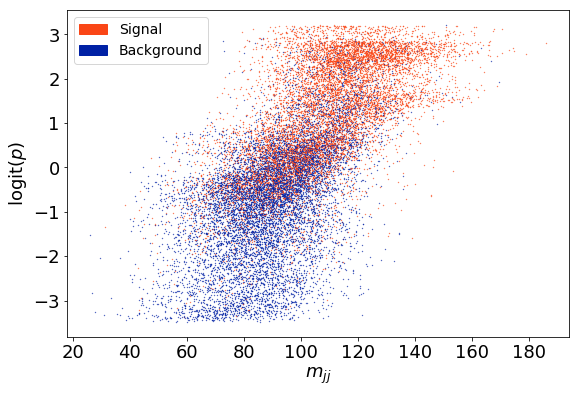

In [13]:
fig, ax = plt.subplots(figsize=(9,6))

plot_batch_size = 100
plot_batch_count = 100

for i in range(plot_batch_count):
    start, end = i*plot_batch_size, (i+1)*plot_batch_size
    ax.scatter(sig_input[start:end, 0], logit(sig_label_pred[start:end]), color=orange, s=.1)
    ax.scatter(bg_input[start:end,0], logit(bg_label_pred[start:end]), color=blue, s=.1)

ax.set_xlabel(r'$m_{jj}$')
ax.set_ylabel(r'$\mathrm{logit}(p)$')

sig_patch = mpatches.Patch(color=orange, label='Signal')
bg_patch = mpatches.Patch(color=blue, label='Background')
ax.legend(handles=[sig_patch, bg_patch], fontsize=14)
None